In [1]:
%run ~/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

In [39]:
glob.glob('s6-l1000fwd_results.dir/*')

['s6-l1000fwd_results.dir/Normal_vs_Wounded-l1000fwd.txt',
 's6-l1000fwd_results.dir/Control_vs_Wounded-l1000fwd.txt',
 's6-l1000fwd_results.dir/Control_vs_Normal-l1000fwd.txt']

In [53]:
results = []
for infile in glob.glob('s6-l1000fwd_results.dir/*')[:-1]:
    dataframe = pd.read_table(infile)
    dataframe['comparison'] = os.path.basename(infile).split('-')[0].replace('_', ' ')
    results.append(dataframe)
result_dataframe = pd.concat(results)
result_dataframe['logp'] = -np.log10(result_dataframe['qvals'])
result_dataframe['drug'] = [rowData['pert_desc'] if rowData['pert_desc'] != '-666' else rowData['pert_id'] for index, rowData in result_dataframe.iterrows()]
result_dataframe['label'] = ['{drug}, {pert_dose}µm, {pert_time}h, {cell_id} cells'.format(**rowData) for index, rowData in result_dataframe.iterrows()]
result_dataframe = result_dataframe.set_index('label', drop=False)
result_dataframe.head()

batch cell_id  \
label                                                                           
NCGC00167094-01, 10.0µm, 24h, VCAP cells              CPC008_VCAP_24H    VCAP   
QS 11, 10.0µm, 24h, PC3 cells                          CPC006_PC3_24H     PC3   
EI-346, 10.0µm, 6h, MCF7 cells                         CPC014_MCF7_6H    MCF7   
geldanamycin, 10.0µm, 6h, MCF7 cells                   CPC016_MCF7_6H    MCF7   
Methyl 2,5-dihydroxycinnamate, 10.0µm, 24h, HCC...  CPC004_HCC515_24H  HCC515   

                                                    combined_scores  \
label                                                                 
NCGC00167094-01, 10.0µm, 24h, VCAP cells                  18.368811   
QS 11, 10.0µm, 24h, PC3 cells                             19.144111   
EI-346, 10.0µm, 6h, MCF7 cells                            19.320529   
geldanamycin, 10.0µm, 6h, MCF7 cells                      19.723542   
Methyl 2,5-dihydroxycinnamate, 10.0µm, 24h, HCC...        15.508988   

                                                                                            distil_id  \
label                                                                                                   
NCGC00167094-01, 10.0µm, 24h, VCAP cells            ['CPC008_VCAP_24H_X1_F1B5_DUO52HI53LO:E22', 'C...   
QS 11, 10.0µm, 24h, PC3 cells                       ['CPC006_PC3_24H_X1_B4_DUO52HI53LO:J22', 'CPC0...   
EI-346, 10.0µm, 6h, MCF7 cells                      ['CPC014_MCF7_6H_X1_B4_DUO52HI53LO:P11', 'CPC0...   
geldanamycin, 10.0µm, 6h, MCF7 cells                ['CPC016_MCF7_6H_X1_B4_DUO52HI53LO:A03', 'CPC0...   
Methyl 2,5-dihydroxycinnamate, 10.0µm, 24h, HCC...  ['CPC004_HCC515_24H_X1_B3_DUO52HI53LO:C06', 'C...   

                                                    mean_cosine_dist_centered_by_batch  \
label                                                                                    
NCGC00167094-01, 10.0µm, 24h, VCAP cells                                      0.851502   
QS 11, 10.0µm, 24h, PC3 cells                                                 0.866142   
EI-346, 10.0µm, 6h, MCF7 cells                                                0.815884   
geldanamycin, 10.0µm, 6h, MCF7 cells                                          0.784870   
Methyl 2,5-dihydroxycinnamate, 10.0µm, 24h, HCC...                            0.697457   

                                                                        pert_desc  \
label                                                                               
NCGC00167094-01, 10.0µm, 24h, VCAP cells                          NCGC00167094-01   
QS 11, 10.0µm, 24h, PC3 cells                                               QS 11   
EI-346, 10.0µm, 6h, MCF7 cells                                             EI-346   
geldanamycin, 10.0µm, 6h, MCF7 cells                                 geldanamycin   
Methyl 2,5-dihydroxycinnamate, 10.0µm, 24h, HCC...  Methyl 2,5-dihydroxycinnamate   

                                                    pert_dose        pert_id  \
label                                                                          
NCGC00167094-01, 10.0µm, 24h, VCAP cells                 10.0  BRD-K95037415   
QS 11, 10.0µm, 24h, PC3 cells                            10.0  BRD-K02526760   
EI-346, 10.0µm, 6h, MCF7 cells                           10.0  BRD-U08759356   
geldanamycin, 10.0µm, 6h, MCF7 cells                     10.0  BRD-A19500257   
Methyl 2,5-dihydroxycinnamate, 10.0µm, 24h, HCC...       10.0  BRD-K88741031   

                                                    pert_time         pvals  \
label                                                                         
NCGC00167094-01, 10.0µm, 24h, VCAP cells                   24  1.328514e-11   
QS 11, 10.0µm, 24h, PC3 cells                              24  4.008786e-12   
EI-346, 10.0µm, 6h, MCF7 cells                              6  8.450928e-12   
geldanamycin, 10.0µm, 6h, MCF7 cells                        6  6.461595e-12   


In [70]:
cast_data = {x: result_dataframe[result_dataframe['direction'] == x].pivot(index='label', columns='comparison', values='logp') for x in result_dataframe['direction'].unique()}
top_signatures = {key: value.sum(axis=1).sort_values(ascending=False).index[:20] for key, value in cast_data.items()}

In [106]:
%%R
stacked_barchart <- function(plot_dataframe, direction, legend_colors) {
  #ticks <- seq()
gp <- ggplot(plot_dataframe, aes(x=reorder(label, logp, FUN=sum), y=logp, fill=comparison)) +
    geom_bar(stat='identity') +
    #facet_wrap(~, scales='free') +
    coord_flip() +
    scale_fill_manual(values=legend_colors) +
    #scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
    #scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
    #scale_x_log10() +
    #scale_y_log10() +
    #scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
    #scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
    #ggtitle('') +
    #geom_abline(intercept=0, slope=1) +
    #xlab('') +
    #ylab('') +
    labs(title = paste0('L1000FWD Prediction - Top ', direction, ' signatures'), x = 'Signatures', y = 'Cumulative -log10P', color = '', fill='Comparison') +
    #guides(fill=FALSE) +
    theme_classic() +
    theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0))  
print(gp)
ggsave(paste0('pipeline/plots/l1000fwd-',direction,'.png'), plot=gp)
}


In [107]:
colors = {
    'similar': np.array(['#FFA961', '#FF7C10']),
    'opposite': np.array(['#B152CC', '#8B10AE'])
}

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

Saving 8 x 5 in image




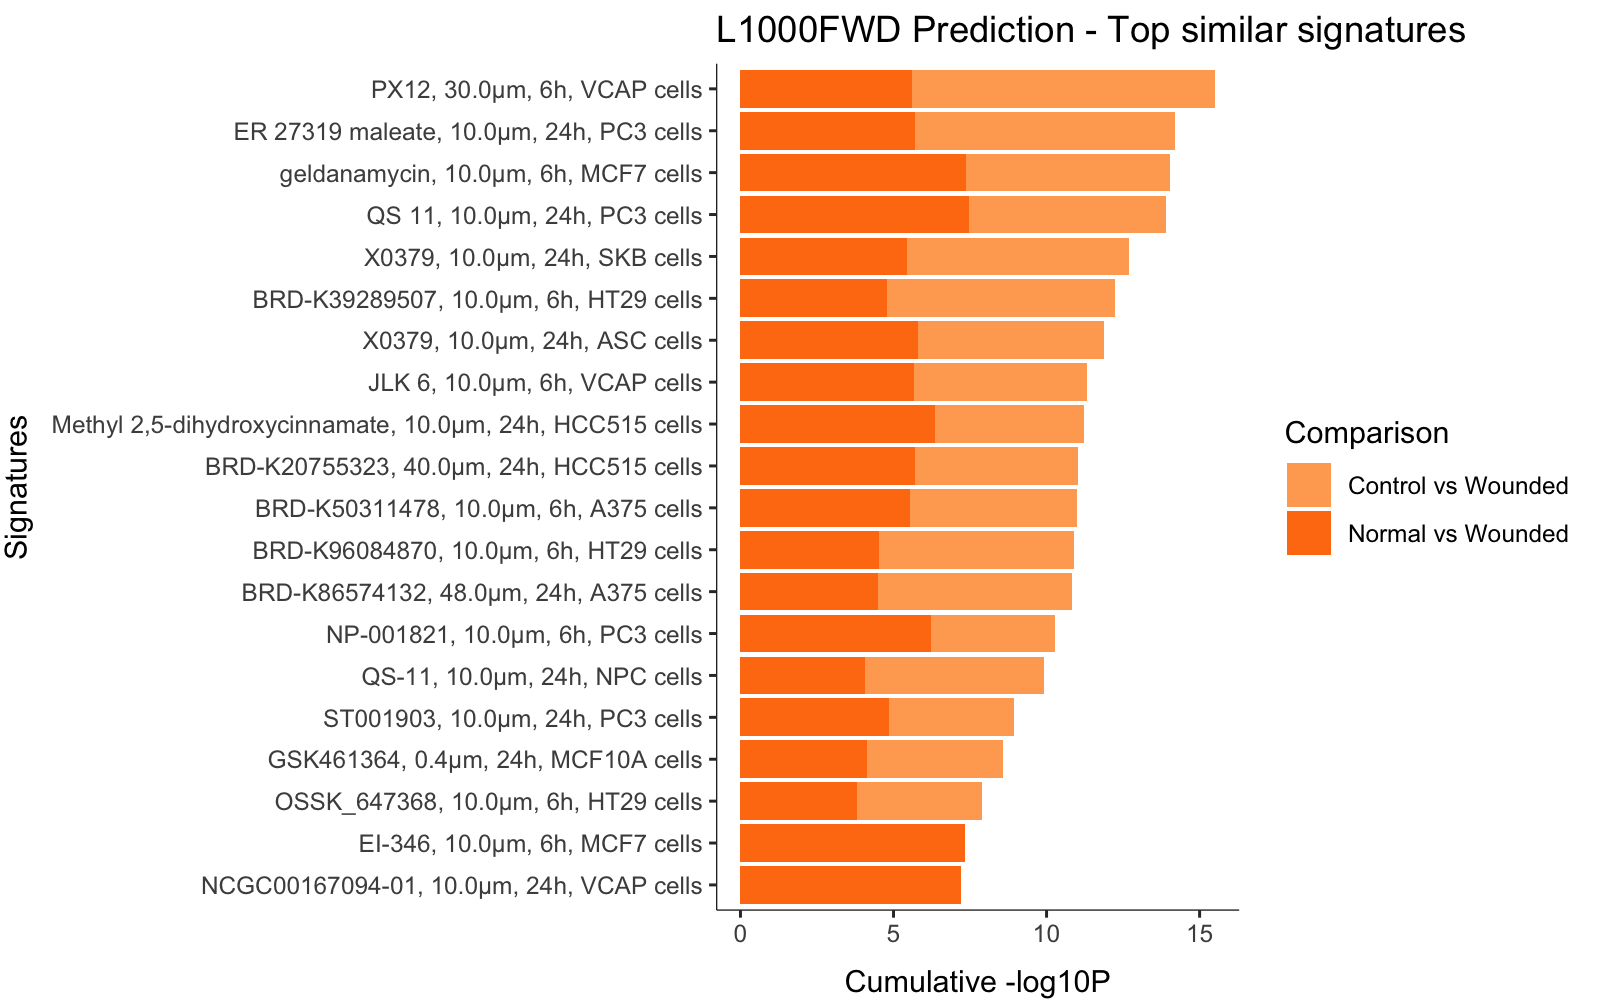

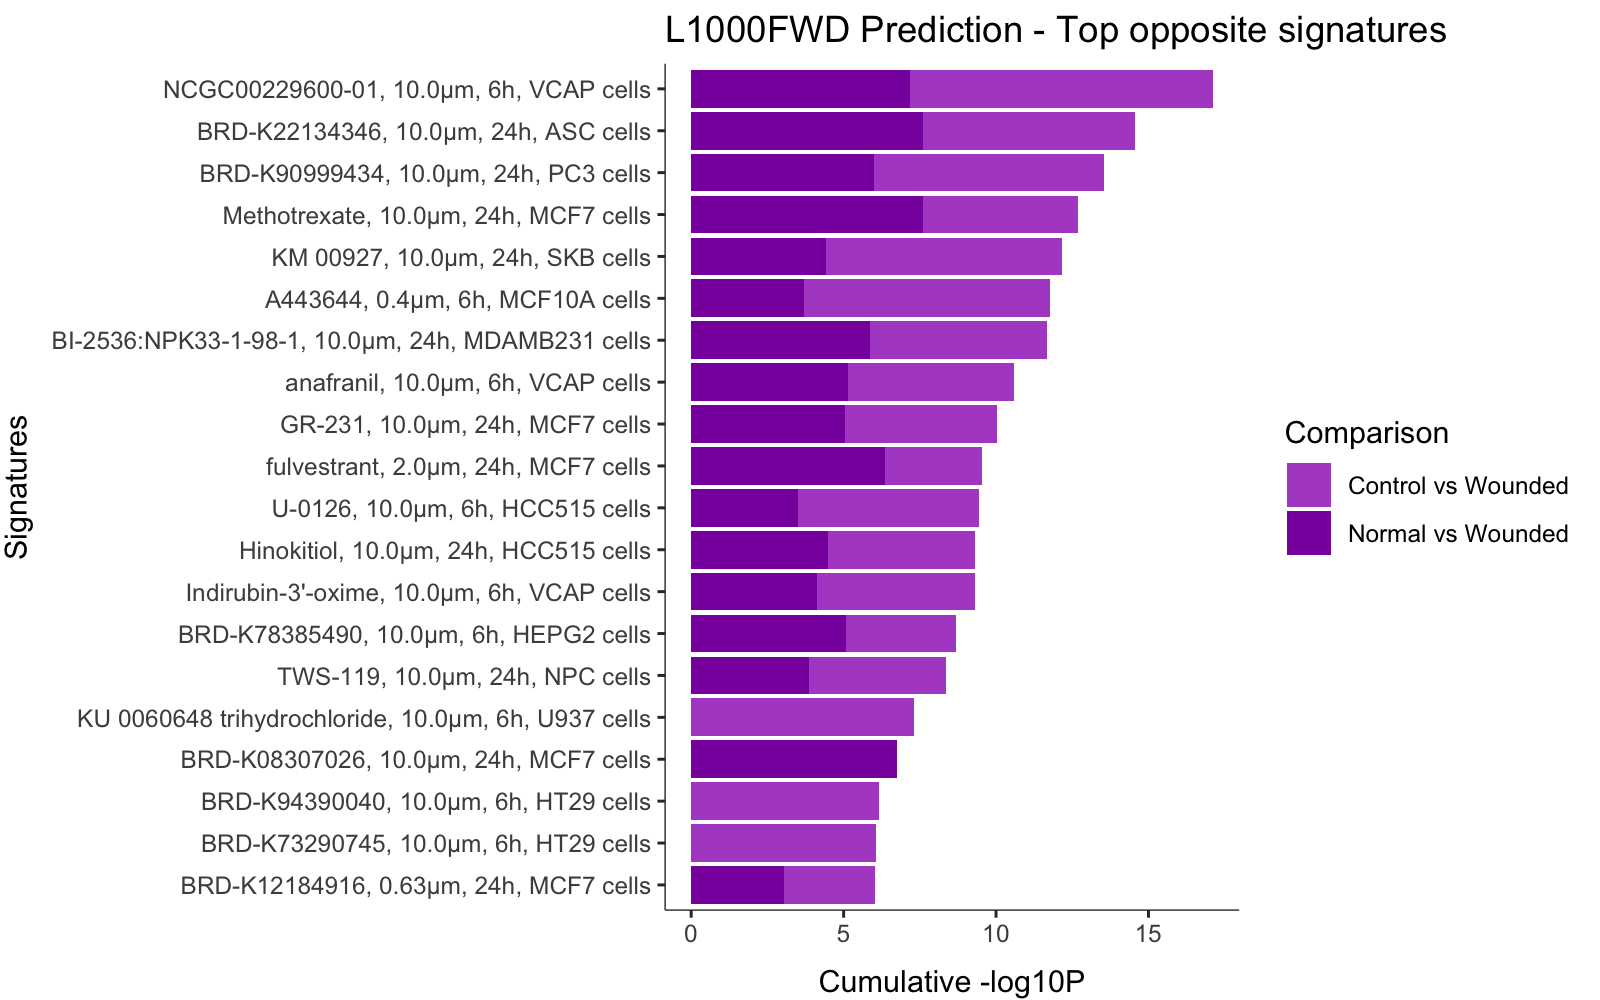

In [108]:
for direction, signatures in top_signatures.items():
    plot_dataframe = result_dataframe[result_dataframe['direction'] == direction].loc[signatures]
    legend_colors = colors[direction]
    %R  -i plot_dataframe,direction,legend_colors -h 1000 -w 1600 -r 200 stacked_barchart(plot_dataframe, direction, legend_colors)